In [1]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cell 2: Paths and config
DATA_PATH = 'bbc_news_text_complexity_summarization.csv'
OUTPUT_DIR = 'bbc_news_project_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

In [3]:
# Cell 3: Load data
print('Loading:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# --- update these to match your CSV ---
TEXT_COL  = 'text'    # your article text column
LABEL_COL = 'labels'  # your target column in this CSV

if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
    raise RuntimeError(f"Expected columns '{TEXT_COL}' and '{LABEL_COL}'. Detected: {df.columns.tolist()}")

Loading: bbc_news_text_complexity_summarization.csv
Shape: (2127, 7)
Columns: ['text', 'labels', 'no_sentences', 'Flesch Reading Ease Score', 'Dale-Chall Readability Score', 'text_rank_summary', 'lsa_summary']


In [4]:
# Cell 4: Quick EDA
print('\nLabel distribution:')
print(df[LABEL_COL].value_counts())
print('\nSample text (first row):\n')
print(df[TEXT_COL].iloc[0][:500])


Label distribution:
labels
sport            505
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

Sample text (first row):

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time W


In [5]:
# Cell 5: Optional - choose summary column to speed up experiments
# If you want to use shorter summaries instead of full text, uncomment one of the lines below.
# X_source = df['text_rank_summary'].fillna(df['text'])
# X_source = df['lsa_summary'].fillna(df['text'])
# Default: use full text
X_source = df[TEXT_COL].fillna('')

In [6]:
# Cell 6: Basic preprocessing function
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# If running for the first time, uncomment below downloads
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    if not isinstance(s, str):
        return ''
    s = s.lower()
    s = re.sub(r"<[^>]+>", ' ', s)                # remove html
    s = re.sub(r"[^a-z0-9\s]", ' ', s)          # remove punctuation
    s = re.sub(r"\s+", ' ', s).strip()
    tokens = [w for w in s.split() if len(w) > 1 and w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [7]:
# Cell 7: Apply cleaning (can toggle for speed)
print('Cleaning texts (this can take a moment)...')
df['clean_text'] = X_source.map(clean_text)

Cleaning texts (this can take a moment)...


In [8]:
# Cell 8: Prepare X, y and split
X = df['clean_text']
y = df[LABEL_COL]

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', list(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
print('Train/Test sizes:', X_train.shape, X_test.shape)

Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']
Train/Test sizes: (1701,) (426,)


In [9]:
# Cell 9: Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000))
])

In [10]:
# Cell 10: (Optional) Quick hyperparameter search — keep small to save time
params = {
    'tfidf__max_features': [8000, 15000],
    'clf__C': [0.5, 1.0]
}

print('Starting GridSearch (this may take several minutes)...')
search = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
print('Best params:', search.best_params_)

best_pipeline = search.best_estimator_

Starting GridSearch (this may take several minutes)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 1.0, 'tfidf__max_features': 8000}


C:\Users\SUMIT YADAV\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\SUMIT YADAV\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Test Accuracy: 0.9859154929577465

Classification Report:

               precision    recall  f1-score   support

     business       1.00      0.97      0.98       101
entertainment       0.97      1.00      0.99        74
     politics       0.98      0.99      0.98        81
        sport       1.00      1.00      1.00       101
         tech       0.97      0.97      0.97        69

     accuracy                           0.99       426
    macro avg       0.98      0.99      0.98       426
 weighted avg       0.99      0.99      0.99       426



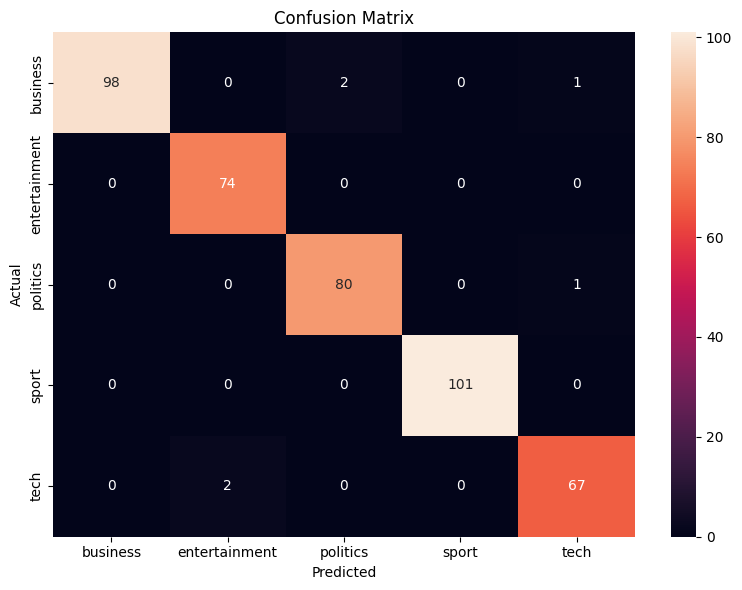

In [11]:
# Cell 11: Evaluate on test set
y_pred = best_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('\nTest Accuracy:', acc)
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()

In [12]:
# Cell 12: Save the pipeline and label encoder
pipe_path = os.path.join(MODELS_DIR, 'tfidf_logreg_pipeline.pkl')
le_path = os.path.join(MODELS_DIR, 'label_encoder.pkl')
with open(pipe_path, 'wb') as f:
    pickle.dump(best_pipeline, f)
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print('Saved pipeline ->', pipe_path)
print('Saved label encoder ->', le_path)

Saved pipeline -> bbc_news_project_output\models\tfidf_logreg_pipeline.pkl
Saved label encoder -> bbc_news_project_output\models\label_encoder.pkl


In [13]:
# Cell 13: Example: using the saved model for one prediction
sample = "The company reported record profits in the last quarter and is expanding into Asia."
with open(pipe_path, 'rb') as f:
    loaded_pipe = pickle.load(f)
with open(le_path, 'rb') as f:
    loaded_le = pickle.load(f)
probs = loaded_pipe.predict_proba([clean_text(sample)])
pred_idx = np.argmax(probs, axis=1)[0]
print('Pred:', loaded_le.inverse_transform([pred_idx])[0], 'Probs:', probs[0])

Pred: business Probs: [0.66531041 0.10234791 0.05049456 0.11323902 0.0686081 ]


In [14]:
# Cell 14: Save a CSV of predictions for the test set (useful for analysis / Streamlit demo)
test_texts = X_test.reset_index(drop=True)
test_df = pd.DataFrame({'text': test_texts, 'true_label': loaded_le.inverse_transform(y_test),
                        'pred_label': loaded_le.inverse_transform(y_pred)})
test_df.to_csv(os.path.join(OUTPUT_DIR, 'test_predictions.csv'), index=False)
print('Saved test predictions CSV')

Saved test predictions CSV
